In [0]:
# Fill in your name using the format below and student ID number
your_name = "Remondini, Leonardo"
student_id = "1518850"

# Assignment 2
The [Speed Dating dataset](https://www.openml.org/d/40536) collects feedback gathered from participants in experimental speed dating events. Every participant rated themselves and their dates according to different attributes (e.g. attractiveness, sincerity, intelligence, fun, ambition, shared interests,...), and whether or not they were interested in a second date. Our goal is to build a machine learning model able to predict whether there will be a match (or not) between two different people. Will you be able to trust your final model?

In [0]:
# imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml

### Additional packages:
* TargetEncoder
    - Run `pip install category_encoders` or `conda install -c conda-forge category_encoders`
* Seaborn (plotting)
    - Run `pip install seaborn` or `conda install seaborn`

In [87]:
# Pre-flight checklist. Do not change this code.
# Make sure that you have installed recent versions of key packages.
# You could lose points if these checks do not pass.
from packaging import version
import sklearn
import category_encoders
import seaborn
sklearn_version = sklearn.__version__
catencoder_version = category_encoders.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(catencoder_version) < version.parse("2.0.0"):
    print("category_encoders is outdated. Please update now!")
else:
    print("OK. You may continue :)")

OK. You may continue :)


In [0]:
# Download Speed Dating data. Takes a while the first time. Do not change this code!
# Note that X is a pandas dataframe 
dates = openml.datasets.get_dataset(40536)
X, y, _, feat_names = dates.get_data(target=dates.default_target_attribute)

In [0]:
# Cleanup. Do not change this code!
# Remove irrelevant or preprocessed columns 
cols = [c for c in X.columns if ((c.lower()[:2] != 'd_' or c.lower() == 'd_age') and c.lower() not in ['wave','has_null'])]
X = X[cols]
classes = ['No match','Match']

# Fix feature name typos
X = X.rename(columns={'ambtition_important': 'ambition_important',
                     'sinsere_o': 'sincere_o'})

# Harmonize the field names somewhat
X['field'] = X['field'].str.lower()
X = X.astype({'field': 'category'})

# Drop columns with more than 10% missing values
missing_counts = X.isnull().sum() * 100 / len(X)
d = {k:v for (k,v) in missing_counts.items() if v>10}
X.drop(d.keys(), axis=1, inplace=True)

# Solves an implementation issue with TargetEncoder
y=y.astype(int)

In [0]:
# THIS WILL BE HELPFUL
# The list of the names of all categorical features
categorical = X.select_dtypes(include=["category"]).columns.tolist()
# The list of the names of all numerical features
numerical = X.select_dtypes(exclude=["category"]).columns.tolist()

### Exploring the data
Uncomment these lines to learn more about the data. Comment or remove to run the notebook faster.

In [0]:
# Peek at the remaining data
# X

In [0]:
# Check the column data types and missing data
#X.info()

In [0]:
# Some categorical columns have a large number of possible values
# Note: It looks like some manual cleaning should be done, but let's move on
#X['field'].value_counts().plot(kind='barh', figsize=(5,40));

In [0]:
# Distributions of numeric data
#X.hist(layout=(20,4), figsize=(20,50));

In [0]:
# What do people find important? Is this related to the outcome (match / no match)?
#import seaborn as sns
#subset = ['attractive_important','ambition_important','attractive_partner','ambition_partner']
#X_sub=X[subset]
#X_sub['match'] = [classes[int(x)] for x in y] 
#sns.set(style="ticks")
#sns.pairplot(X_sub, hue="match");

## Part 1: Preprocessing

### Question 1.1 (5 points)
Implement a function `simple_pipeline` that returns an sklearn pipeline that preprocesses the data in a minimal way before running a classifier:
- Categorical features:
    - Impute missing values by replacing them with the most frequent value for that feature
    - Perform one-hot encoding. Use `sparse=False` to avoid that it returns a sparse datasets. Use `handle_unknown='ignore'` to ignore categorical values that where not seen during training.
- Numeric features:
    - Remove missing values by replace missing values with the mean value for that feature

In [0]:
# Implement
def simple_pipeline(categorical, clf):
    """ Returns a minimal pipeline that imputes missing values and does one-hot-encoding for categorical features
    Keyword arguments:
    categorical -- A list of categorical column names. Example: ['gender', 'country'].
    clf -- any scikit-learn classifier
    Returns: a scikit-learn pipeline which preprocesses the data and then runs the classifier
    """
    cat_pipe = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='most_frequent'), OneHotEncoder(sparse=False)) 
    num_pipe = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))

    transform = make_column_transformer((cat_pipe, categorical), remainder=num_pipe)
    pipe = sklearn.pipeline.Pipeline([("preprocess", transform), ("classifier", clf)])

    return pipe
    pass

#### Sanity check
To be correct, this pipeline should be able to fit any classifier without error. Uncomment and run this code to do a sanity check.

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

data = simple_pipeline(categorical, DecisionTreeClassifier()).fit(X,y);

### Question 1.2 (1 point)
How many features are being constructed by this pipeline (i.e. on how many features is the classifier trained)?

In [0]:
# Fill in the correct answer, should be an integer. Don't change the name of the variable
q_1_2 = 287

### Question 1.3 (3 points)
Implement a function `flexible_pipeline` that has two additional options:
- Allow to add a feature scaling method for numeric features. The default is standard scaling. 'None' means no scaling
- Allow the one-hot encoder to be replaced with another encoder, The default is one-hot encoding.

In [0]:
# Implement
from sklearn.preprocessing import StandardScaler, OneHotEncoder
def flexible_pipeline(categorical, clf, scaler=StandardScaler(), encoder=OneHotEncoder(sparse=False)):
    """ Returns a pipeline that imputes all missing values, encodes categorical features and scales numeric ones
    Keyword arguments:
    categorical -- A list of categorical column names. Example: ['gender', 'country'].
    clf -- any scikit-learn classifier
    scaler -- any scikit-learn feature scaling method (Optional)
    encoder -- any scikit-learn category encoding method (Optional)
    Returns: a scikit-learn pipeline which preprocesses the data and then runs the classifier
    """

    cat_pipe = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='most_frequent'), encoder) 
    num_pipe = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'))

    if scaler != None:
      num_pipe.steps.insert(1,["scaler", scaler]) 

    transform = make_column_transformer((cat_pipe, categorical), remainder=num_pipe)
    pipe = sklearn.pipeline.Pipeline([("preprocess", transform), ("classifier", clf)])
    
    return pipe

    pass

### Question 1.4 (3 points)
Implement a function `plot_1_4` which plots a heatmap comparing several combinations of scaling methods and classifiers:
* As classifiers, the following algorithms in their default hyperparameters settings: 
    * Logistic regression
    * SVM with RBF kernel
    * Random Forest
* As options, the following feature scaling options in their default settings:
    * No scaling
    * Standard scaling
    * Normalize
    * PowerTransformer
* In all cases, use OneHotEncoder with `sparse=False` and `handle_unknown='ignore'`

You should evaluate all pipelines using AUC (area under the ROC curve) with 3-fold cross-validation. 
Compare all methods with the same cross-validation folds, shuffle the data and use `random_state=1`.
Where possible, also use `random_state=1` for the classifiers. 
Only report the test scores (not the training scores).

In [0]:
### Helper plotting function. Do not change.
import seaborn as sns
import random
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer, PowerTransformer
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

def heatmap(columns, rows, scores):
    """ Simple heatmap.
    Keyword arguments:
    columns -- list of options in the columns
    rows -- list of options in the rows
    scores -- numpy array of scores
    """
    df = pd.DataFrame(scores, index=rows, columns=columns)
    sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True, fmt=".3f")

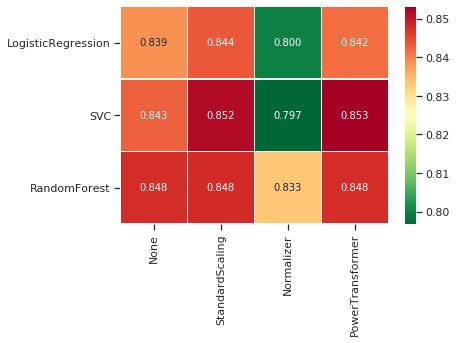

In [64]:
# Implement
def plot_1_4(X, y):
    """ Evaluates 3 classifiers together with 4 types of scaling. See description above.
    """
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    classifier = [LogisticRegression(random_state=1), SVC(random_state=1), RandomForestClassifier(random_state=1)]
    scaler = [None, StandardScaler(), Normalizer(), PowerTransformer()]
    scores = []

    for clf in classifier:
      row = []
      for scl in scaler:
        pipe = flexible_pipeline(categorical, clf, scaler=scl)
        score = cross_val_score(pipe, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)
        row.append(score.mean())
      scores.append(row)
    
    rows = ['LogisticRegression', 'SVC', 'RandomForest']
    columns = ['None', 'StandardScaling', 'Normalizer', 'PowerTransformer']
    heatmap(columns, rows, scores)
    pass
  
plot_1_4(X,y)

### Question 1.5 (1 point)
Interpret the heatmap of Question 1.4. Which of the following are correct?  
Enter your answer as a comma-separated string without spaces, e.g. "A,B,C"
- 'A': All scaling methods perform equally well. It doesn't matter which scaling method is used.
- 'B': The best scaling method depends on the classifier that will be used.
- 'C': Scaling is important for SVMs and logistic regression, but not needed for Random Forests.
- 'D': The power transformer is much better than other techniques on this dataset because many features have a power law distribution.
- 'E': The Normalizer works badly because information gets lost in the scaling.
- 'F': No answer

In [0]:
# Fill in the correct answers, e.g. 'A,B,C'. Don't change the name of the variable
q_1_5 = 'B,C'

### Question 1.6 (3 points)
Optimize the encoding method for the categorical features. Use your `flexible_pipeline` to compare OneHotEncoding and TargetEncoding
together with the same 3 classifiers as in question 1.4. Always use standard scaling. Implement a function `plot_1_6` which plots a heatmap with the results.

TargetEncoding is part of the category encoders extension of scikit-learn. [Read more about it.](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html)

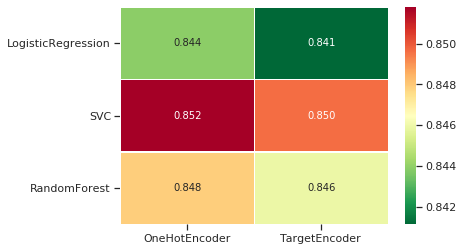

In [65]:
from category_encoders import TargetEncoder
# Implement
def plot_1_6(X, y):
    """ Evaluates 3 classifiers and plots the results in a bar chart.
    Also compares different category encoders
    """
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    classifier = [LogisticRegression(random_state=1), SVC(random_state=1), RandomForestClassifier(random_state=1)]
    encoder = [OneHotEncoder(sparse=False, handle_unknown='ignore'), TargetEncoder()]
    scores = []

    for clf in classifier:
      row = []
      for enc in encoder:
        pipe = flexible_pipeline(categorical, clf, encoder=enc)
        score = cross_val_score(pipe, X, y, cv=kfold, scoring='roc_auc', n_jobs=-1)
        row.append(score.mean())
      scores.append(row)

    rows = ['LogisticRegression', 'SVC', 'RandomForest']
    columns = ['OneHotEncoder', 'TargetEncoder']
    heatmap(columns, rows, scores)
    pass

plot_1_6(X,y)

### Question 1.7 (1 point)
Interpret the heatmap of Question 1.6. Which of the following are correct?  
Enter your answer as a comma-separated string without spaces, e.g. "A,B,C"
- 'A': They perform equally well
- 'B': Target encoding is slightly better
- 'C': One-hot-encoding is slightly better
- 'D': It depends on the algorithm.
- 'E': No answer

In [0]:
# Fill in the correct answers, e.g. 'A,B,C'. Don't change the name of the variable
q_1_7 = 'C'

### Question 1.8 (1 point)
How many features are being constructed by the target encoder pipeline (i.e. on how many features is the classifier trained)?

In [0]:
# Fill in the correct answer, should be an integer. Don't change the name of the variable
q_1_8 = 59

## Part 2: Feature importance
In this part, we will continue with your `flexible_pipeline`, and we use a random forest to learn which features
are most important to predict the outcome of a dating 'match'. We will do this with both Random Forest's importance estimates and with permutation importance.

### Question 2.1 (5 points)
Implement a function `plot_2_1` that does the following:  
* Split the data using a standard stratified and shuffled train-test split. Use `random_state=1`.
* Combine your `flexible_pipeline`, without feature scaling but with one-hot-encoding, with a RandomForest classifier. Train that pipeline on the training set.
* Remember that the categorical features where encoded. Retrieve their encoded names from the one-hot-encoder (with `get_feature_names`).
* Retrieve the feature importances from the trained random forest and match them to the correct names. Depending on how you implemented your `flexible_pipeline` these are likely the first or the last columns in the processed dataset.
* Compute the permutation importances given the random forest pipeline and the test set. Use `random_state=1` and at least 10 iterations.
* Pass the tree-based and permutation importances to the plotting function `compare_importances` below.

In [0]:
# Plotting function. Do not edit.
def compare_importances(rf_importance, perm_importance, rf_feature_names, feature_names):
    """ Compares the feature importances from random forest to permutation importance
    Keyword arguments:
    rf_importance -- The random forest's feature_importances_
    perm_importance -- The permutation importances as computed by sklearn.inspection.permutation_importance
    rf_feature_names -- The names of the features received by the random forest, in the same order as their importances
    feature_names -- The original features names in their original order
    """
    topk = 30
    # Trees
    sorted_idx = rf_importance.argsort()[-topk:]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    y_ticks = np.arange(0, topk)
    ax[0].barh(y_ticks, rf_importance[sorted_idx])
    ax[0].set_yticklabels(rf_feature_names[sorted_idx])
    ax[0].set_yticks(y_ticks)
    ax[0].set_title("Random Forest Feature Importances")

    # Permutations
    sorted_idx = perm_importance.importances_mean.argsort()[-topk:]
    ax[1].boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx])
    ax[1].set_title("Permutation Importances (test set)")

    fig.tight_layout()
    plt.show()

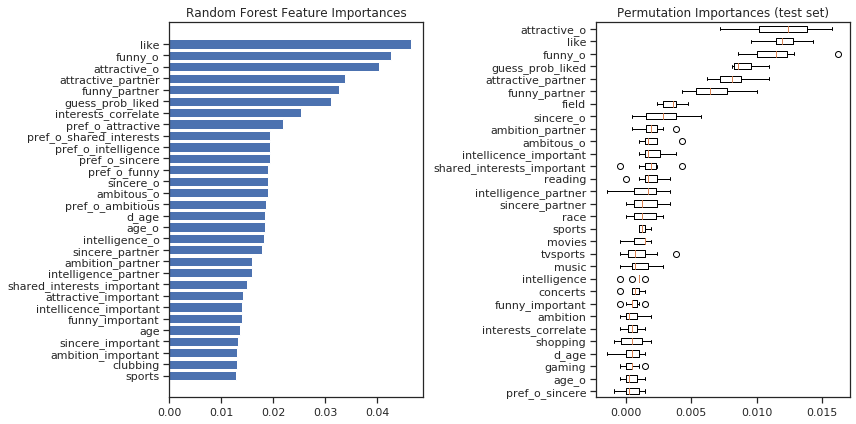

In [84]:
# Implement
from sklearn.inspection import permutation_importance

def plot_2_1(X, y):
    """ See detailed description above.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, shuffle=True, stratify=y)
    pipe = flexible_pipeline(categorical, RandomForestClassifier(random_state=1), scaler=None)
    pipe.fit(X_train, y_train)

    enc_feat_names = pipe['preprocess'].transformers_[0][1]['onehotencoder'].get_feature_names(input_features=categorical)
    enc_feat_names = np.r_[enc_feat_names, numerical]
    feature_importances = pipe[1].feature_importances_
    permutation_imp = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=1, n_jobs=-1)

    compare_importances(feature_importances, permutation_imp, enc_feat_names, X_test.columns)
    pass

plot_2_1(X, y)

### Question 2.2 (1 point)
Interpret the results of Question 2.1. Which of the following are correct?  
Enter your answer as a comma-separated string without spaces, e.g. "A,B,C"
- 'A': The topmost feature importances are roughly the same for both methods
- 'B': The topmost feature importances are very different
- 'C': Categorical features (race, race_o, field,...) are ranked higher in the random forest ranking
- 'D': Categorical features are ranked lower in the random forest ranking
- 'E': No answer

In [0]:
# Fill in the correct answers, e.g. 'A,B,C'. Don't change the name of the variable
q_2_2 = 'A,D'

## Part 3: Calibrating predictions
### Question 3.1 (2 points)
Use a grid search to optimize the RandomForest pipeline from question 2.1. Vary the number of trees from 100 to 1500 and `max_features` from
0.05 to 0.1. Use at least 2 values for every hyperparameter. Evaluate all pipelines using AUC (area under the ROC curve) with 3-fold cross-validation. Compare all methods with the same cross-validation folds, shuffle the data and use `random_state=1`.
Plot the results in a heatmap in function `plot_3_1`.

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


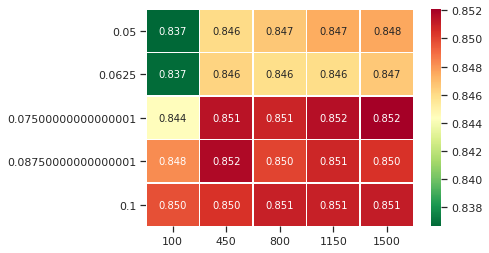

In [68]:
#Implement
from sklearn.model_selection import GridSearchCV

def plot_3_1(X, y):
    """ See detailed description above.
    """
    param_grid = {
        'classifier__n_estimators': np.linspace(100, 1500, num=5, dtype=int),
        'classifier__max_features': np.linspace(0.05, 0.1, num=5, dtype=float)
    }
    
    kfold = StratifiedShuffleSplit(n_splits=3, random_state=1)
    pipe = flexible_pipeline(categorical, RandomForestClassifier(random_state=1), scaler=None)
    grid_search = GridSearchCV(pipe, param_grid, cv=kfold, scoring='roc_auc', n_jobs=-1)
    results = grid_search.fit(X, y)

    scores = grid_search.cv_results_['mean_test_score'].reshape(len(param_grid['classifier__n_estimators']),len(param_grid['classifier__max_features']))
    heatmap(param_grid['classifier__n_estimators'], param_grid['classifier__max_features'], scores)   

    pass

plot_3_1(X,y)

### Question 3.2 (2 points)
Implement a function `plot_3_2` that plots the ROC curve for the Random Forest pipeline with `n_estimators=1000`.
Also indicate the point on the curve that corresponds to the 0.5 probability decision threshold.

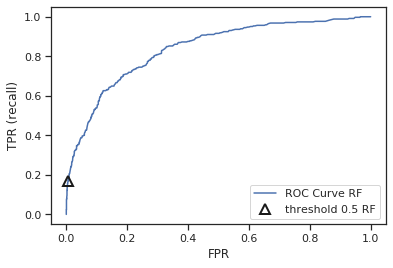

In [69]:
#Implement
from sklearn.metrics import roc_curve

def plot_3_2(X, y):
    """ See description above.
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
    pipe = flexible_pipeline(categorical, RandomForestClassifier(n_estimators=1000, random_state=1), scaler=None)
    pipe.fit(X_train, y_train)

    fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, pipe.predict_proba(X_test)[:,1])

    plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
    plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
              label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4);



plot_3_2(X, y)

### Question 3.3 (2 points)
Calibrate your model to get a higher recall. What would be the optimal decision threshold (approximately) assuming that a false negative (missing a good match) is twice as bad as a false positive (going on a date with someone who is not a good match)? The grade will depend on the distance to the actual optimum (within a tolerance).

In [0]:
# Fill in the correct answer, should be a float. Don't change the name of the variable
q_3_3 = 0.137